In [22]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.utils import shuffle

In [23]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
IsSynthetic = False

In [24]:
def GenerateRawData(filePath):    
    Feature = pd.read_csv('GSC-Features.csv', index_col=False)
    Samepair = pd.read_csv('same_pairs.csv')
    Samepair = Samepair.sample(10000)
    Diffpair = pd.read_csv('diffn_pairs.csv')
    Diffpair_new = Diffpair.sample(10000)
    listy = [Samepair, Diffpair_new]
    mixed = pd.concat(listy)
    mixed_shuffled = shuffle(mixed) 
    t = mixed_shuffled['target']
    t = t.as_matrix()   
    mixed_shuffled = mixed_shuffled.drop(['target'], axis = 1)
    data1 = pd.merge(left=mixed_shuffled, right=Feature, left_on='img_id_A', right_on='img_id')
    data1 = data1.loc[:, ~data1.columns.str.contains('^img_id')]
    data2 = pd.merge(left=mixed_shuffled, right=Feature, left_on='img_id_B', right_on='img_id')
    data2 = data2.loc[:, ~data2.columns.str.contains('^img_id')]
    data3 = data1.sub(data2)

    dataMatrix = data3.as_matrix()
    dataMatrix = np.transpose(dataMatrix)
    return dataMatrix,t

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

def sigmoid(data,w):
    x = np.dot(w,data)
    y = 1 / (1 + np.exp(-x))
    return y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [25]:
RawData, RawTarget = GenerateRawData('GSC-Features.csv')
print(RawData.shape)
print(RawTarget.shape)

C:\Users\sagni\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


(512, 20000)
(20000,)


C:\Users\sagni\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Prepare Training Data

In [26]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
r,c = TrainingData.shape
print(TrainingTarget.shape)
print(TrainingData.shape)

(16000,)
(512, 16000)


## Prepare Validation Data

In [27]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(1999,)
(512, 1999)


## Prepare Test Data

In [28]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(1999,)
(512, 1999)


## Logistic Regression

In [29]:
W_Now        = np.ones(r)
Target_new   = np.zeros(c)
learningRate = 0.05
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
index        = []

for i in range(0,800):
    
    index.append(i)
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    y             = sigmoid(TrainingData,W_Now)
    Target_new    = np.subtract(TrainingTarget,y)
    Delta_E       = np.dot(Target_new,np.transpose(TrainingData))/r  
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = y 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[0]))

for i in range(0,800):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    y             = sigmoid(ValData,W_Now)
    Target_new    = np.subtract(ValDataAct,y)
    Delta_E       = np.dot(Target_new,np.transpose(ValData))/r  
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = y 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[0]))

for i in range(0,800):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    y             = sigmoid(TestData,W_Now)
    Target_new    = np.subtract(TestDataAct,y)
    Delta_E       = np.dot(Target_new,np.transpose(TestData))/r  
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = y
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[0]))


In [30]:
print ('----------Gradient Descent Solution--------------------')
print ("Accuracy Training   = " + str(np.around(max(L_Erms_TR),5)))
print ("Accuracy Validation = " + str(np.around(max(L_Erms_Val),5)))
print ("Accuracy Testing    = " + str(np.around(max(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
Accuracy Training   = 50.175
Accuracy Validation = 50.97549
Accuracy Testing    = 49.92496


C:\Users\sagni\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  """Entry point for launching an IPython kernel.


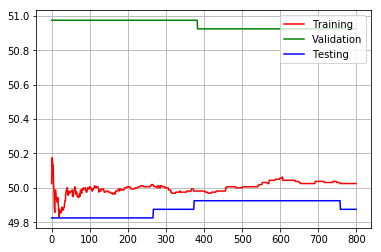

In [31]:
plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])
plt.grid()
plt.plot(index, L_Erms_TR)
plt.plot(index, L_Erms_Val)
plt.plot(index, L_Erms_Test)
plt.legend(['Training', 'Validation', 'Testing'], loc='upper right')